In [297]:
%matplotlib inline
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
import tensorflow as tf
# from keras import backend as K
import keras.backend.tensorflow_backend as K
K.set_session

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras import backend as keras

In [249]:
os.getcwd()
TRAIN_PATH = "data/stage1_train/"
train_ids = next(os.walk(TRAIN_PATH))[1]
# test_ids = next(os.walk(TEST_PATH))[1]

In [267]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

## Train data loader function

In [268]:

def load_train_data(number_of_img=None):
    X_train = np.zeros((number_of_img or len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y_train = np.zeros((number_of_img or len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    sys.stdout.flush()
    if number_of_img:
        enumerate_coll = enumerate(train_ids)
    else:
        print('Getting and resizing train images and masks ... ')
        enumerate_coll = tqdm(enumerate(train_ids), total=len(train_ids))
    for n, id_ in enumerate_coll:
        if number_of_img and number_of_img == n:
            break
        path = TRAIN_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[n] = img
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                          preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)
        Y_train[n] = mask
    return X_train, Y_train


### Plot Data

In [269]:
def plot_original_data(number_of_img=7):
    X_train, Y_train = load_train_data(number_of_img)

    if number_of_img ==1:
        f, axarr = plt.subplots(number_of_img,2,figsize=(15,6))
        axarr[0].imshow(X_train[0])
        axarr[1].imshow(np.squeeze(Y_train[0]))
    else:
        f, axarr = plt.subplots(2,number_of_img,figsize=(15,6))
        for i in range(0,number_of_img):   
            axarr[0,i].imshow(X_train[i])
            axarr[1,i].imshow(np.squeeze(Y_train[i]))

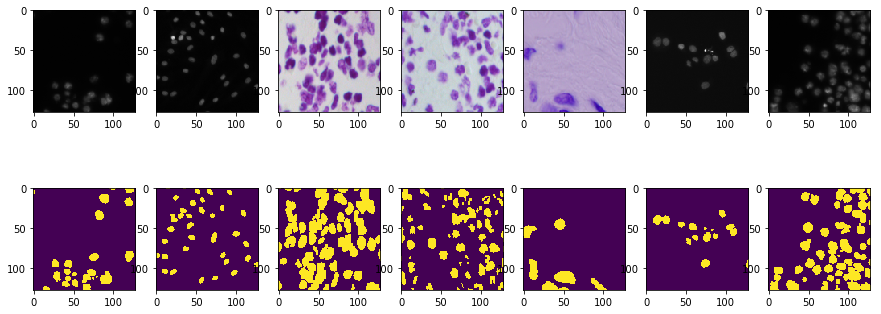

In [270]:
plot_original_data()

## Thresholding Method

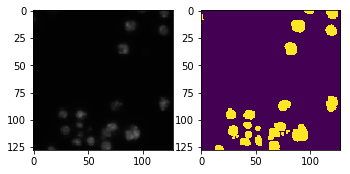

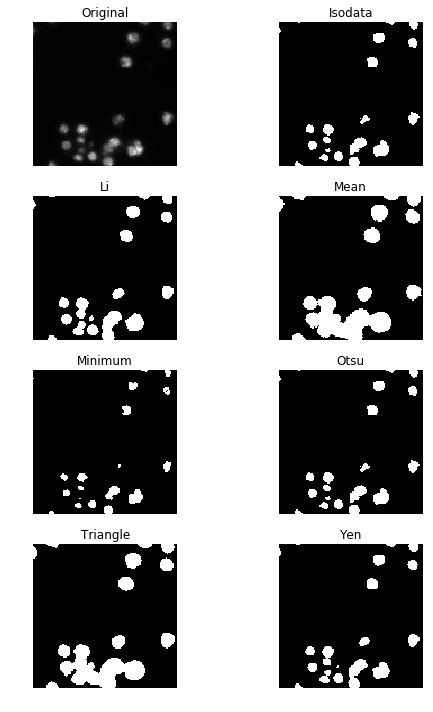

In [254]:
from skimage.filters import try_all_threshold

def thresholding_method():
    X_train, Y_train = load_train_data(1)
    
    f, axarr = plt.subplots(1,2,figsize=(5.5,10))
    axarr[0].imshow(X_train[0])
    axarr[1].imshow(np.squeeze(Y_train[0]))

    fig, ax = try_all_threshold(X_train[0][:, :, 0], figsize=(8, 10), verbose=False)
    plt.show()

thresholding_method()


### Threshold Yen

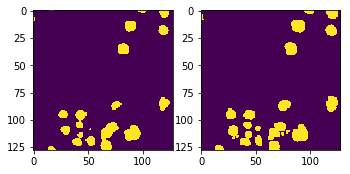

In [255]:
from skimage.filters import threshold_yen

X_train, Y_train = load_train_data(1)
image = X_train[0][:, :, 0]
thresh = threshold_yen(image)
binary = np.array( image > thresh, dtype=int)
f, axarr = plt.subplots(1,2,figsize=(5.5,10))
axarr[0].imshow(binary)
axarr[1].imshow(np.squeeze(Y_train[0]))


In [256]:
def simple_iou(component1,component2):
    overlap = component1*component2 # Logical AND
    union = component1 + component2 # Logical OR
    IOU = overlap.sum()/float(union.sum())
    return IOU

In [257]:
simple_iou(binary,np.squeeze(Y_train[0]))

0.42348877374784111

# KERAS Model

In [293]:
def unet(pretrained_weights = None,input_size = (128,128,3)):
    """
    this is an implementation for U-net with keras
    the original imput shape was 256x256x1 -> 64 ->128 ->512 -> 1024, 
    i would use 128x128x3 -> 4 ->8 -> 16 ->32 in order to test it on my own cpu 
    since i start with half of dimensions, i would also exclude one pooling group 
    """
    inputs = Input(input_size)
    
    conv1 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)

    up5 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop4))
    merge5 = merge([conv3,up5], mode = 'concat', concat_axis = 3)
    conv5 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge5)
    conv5 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)

    up6 = Conv2D(8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = merge([conv2,up6], mode = 'concat', concat_axis = 3)
    conv6 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = merge([conv1,up7], mode = 'concat', concat_axis = 3)
    conv7 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv8 = Conv2D(1, 1, activation = 'sigmoid')(conv7)

    model = Model(input = inputs, output = conv8)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [295]:
X_train, Y_train = load_train_data(1000)

In [303]:
model = unet()
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('keras_model-2018-Data-Science-Bowl-v1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=30, verbose=0,
                    callbacks=[earlystopper, checkpointer])

C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
C:\Users\Sharon\Anaconda3\lib\site-packages\keras\legacy\layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.p

Epoch 00000: val_loss improved from inf to 0.66485, saving model to keras_model-2018-Data-Science-Bowl-v1.h5
Epoch 00001: val_loss improved from 0.66485 to 0.63285, saving model to keras_model-2018-Data-Science-Bowl-v1.h5
Epoch 00002: val_loss improved from 0.63285 to 0.58649, saving model to keras_model-2018-Data-Science-Bowl-v1.h5
Epoch 00003: val_loss improved from 0.58649 to 0.49938, saving model to keras_model-2018-Data-Science-Bowl-v1.h5
Epoch 00004: val_loss improved from 0.49938 to 0.22962, saving model to keras_model-2018-Data-Science-Bowl-v1.h5
Epoch 00005: val_loss improved from 0.22962 to 0.01593, saving model to keras_model-2018-Data-Science-Bowl-v1.h5
Epoch 00006: val_loss improved from 0.01593 to 0.00968, saving model to keras_model-2018-Data-Science-Bowl-v1.h5
Epoch 00007: val_loss improved from 0.00968 to 0.00550, saving model to keras_model-2018-Data-Science-Bowl-v1.h5
Epoch 00008: val_loss improved from 0.00550 to 0.00356, saving model to keras_model-2018-Data-Scienc

In [294]:
unet().summary()

C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
C:\Users\Sharon\Anaconda3\lib\site-packages\keras\legacy\layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.p

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_10 (InputLayer)            (None, 128, 128, 3)   0                                            
____________________________________________________________________________________________________
conv2d_152 (Conv2D)              (None, 128, 128, 4)   112         input_10[0][0]                   
____________________________________________________________________________________________________
conv2d_153 (Conv2D)              (None, 128, 128, 4)   148         conv2d_152[0][0]                 
____________________________________________________________________________________________________
max_pooling2d_30 (MaxPooling2D)  (None, 64, 64, 4)     0           conv2d_153[0][0]                 
___________________________________________________________________________________________

In [278]:
unet(pretrained_weights = None,input_size = (256,256,1)).summary()

C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
C:\Users\Sharon\Anaconda3\lib\site-packages\keras\legacy\layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
C:\Users\Sharon\Anaconda3\lib\site-packages\ipykernel_launcher.p

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 256, 256, 1)   0                                            
____________________________________________________________________________________________________
conv2d_25 (Conv2D)               (None, 256, 256, 64)  640         input_2[0][0]                    
____________________________________________________________________________________________________
conv2d_26 (Conv2D)               (None, 256, 256, 64)  36928       conv2d_25[0][0]                  
____________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)   (None, 128, 128, 64)  0           conv2d_26[0][0]                  
___________________________________________________________________________________________

conv2d_47 (Conv2D)               (None, 256, 256, 2)   1154        conv2d_46[0][0]                  
____________________________________________________________________________________________________
conv2d_48 (Conv2D)               (None, 256, 256, 1)   3           conv2d_47[0][0]                  
Total params: 31,031,685
Trainable params: 31,031,685
Non-trainable params: 0
____________________________________________________________________________________________________


C:\Users\Sharon\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


TypeError: peak_local_max() got an unexpected keyword argument 'abels'

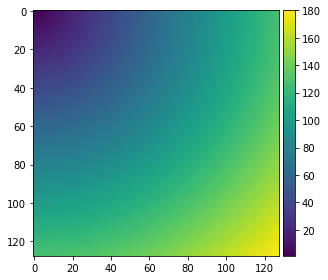

In [247]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.feature import peak_local_max


image = X_train[0][:, :, 0]
# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance= ndi.distance_transform_edt(image)
imshow(distance)
local_maxi = peak_local_max(distance, indices=False, abels=image)

print(local_maxi)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=image)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral, interpolation='nearest')
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()